In [10]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from scipy import stats
import numpy as np

def get_ohlcv_yf(code,start="2021-01-01",end="2024-12-31", interval="1d"): #interval = [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
    ohlcv = yf.download(code,start=start,end=end, interval=interval)
    ohlcv.columns = ohlcv.columns.droplevel(1)
    ohlcv.columns.name = None
    ohlcv.index.name = None
    ohlcv["Return"] = (ohlcv["Close"] - ohlcv["Open"]) / ohlcv["Open"]
    return ohlcv

def plot_ohclv(ohlcv):
    fig = plt.figure(figsize=(15,6))

    for i, feature in enumerate(["Close","High","Low","Open","Volume","Return"]):
        ax = plt.subplot(3,2,i+1)
        ax.set_title(feature)
        ohlcv[feature].tail(500).plot(ax=ax)
    plt.tight_layout()

def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

In [23]:
### 検証銘柄と検証特徴量###
objective = "9531.T"
feature = "NG=F"
#########################

####### 検証条件 ########
start = "2021-01-01"
end = "2024-12-31"
interval = "1d"
########################

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,Return
2021-01-04,2150.768311,2189.774231,2144.872067,2175.260400,661800,-0.011259
2021-01-05,2135.800781,2162.107098,2126.729638,2162.107098,1134300,-0.012167
2021-01-06,2145.325684,2145.779241,2111.308892,2120.833593,1003600,0.011548
2021-01-07,2158.479004,2192.949356,2154.850546,2188.413783,1280900,-0.013679
2021-01-08,2175.260498,2177.981841,2133.986790,2144.872163,1371300,0.014168
...,...,...,...,...,...,...
2024-12-24,4394.000000,4402.000000,4332.000000,4341.000000,926800,0.012209
2024-12-25,4368.000000,4386.000000,4315.000000,4377.000000,684300,-0.002056
2024-12-26,4376.000000,4391.000000,4354.000000,4368.000000,690900,0.001832
2024-12-27,4425.000000,4425.000000,4375.000000,4400.000000,791700,0.005682


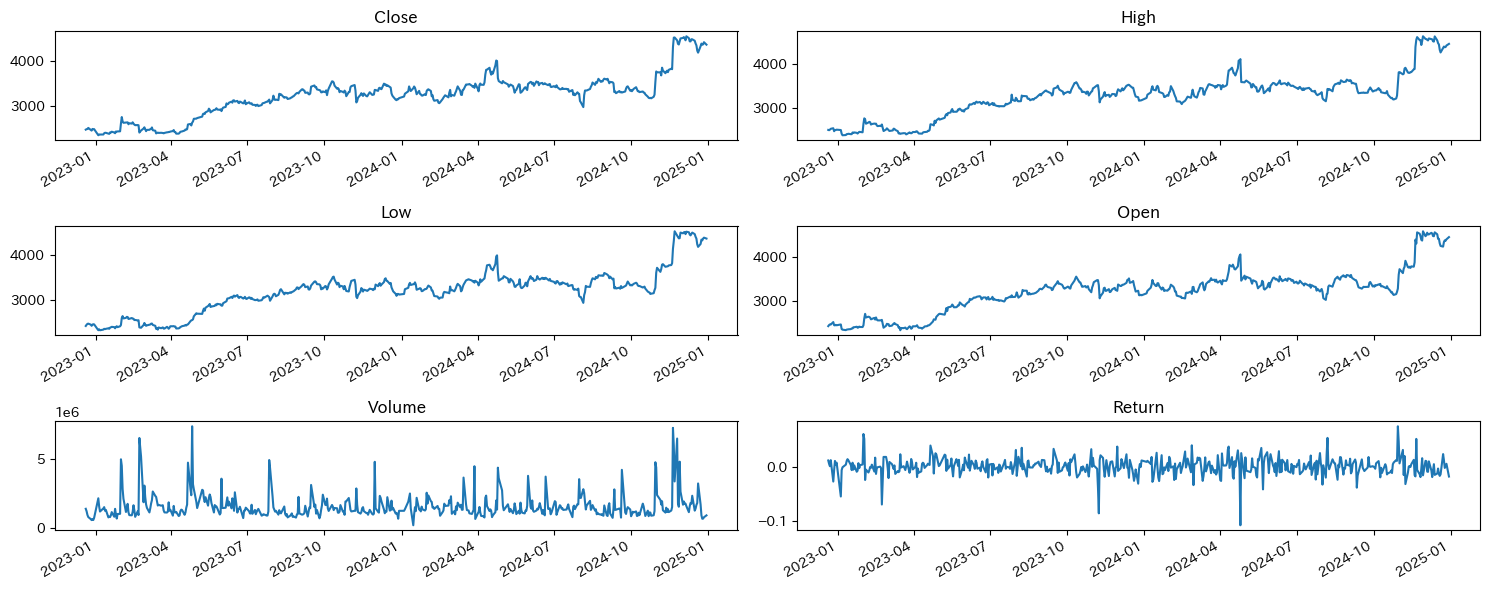

In [24]:

objective_ohlcv = get_ohlcv_yf(objective, start = start,end = end, interval= interval)
plot_ohclv(objective_ohlcv)
objective_ohlcv.isnull().sum()
objective_ohlcv

[*********************100%***********************]  1 of 1 completed

Close     0
High      0
Low       0
Open      0
Volume    0
Return    0
dtype: int64

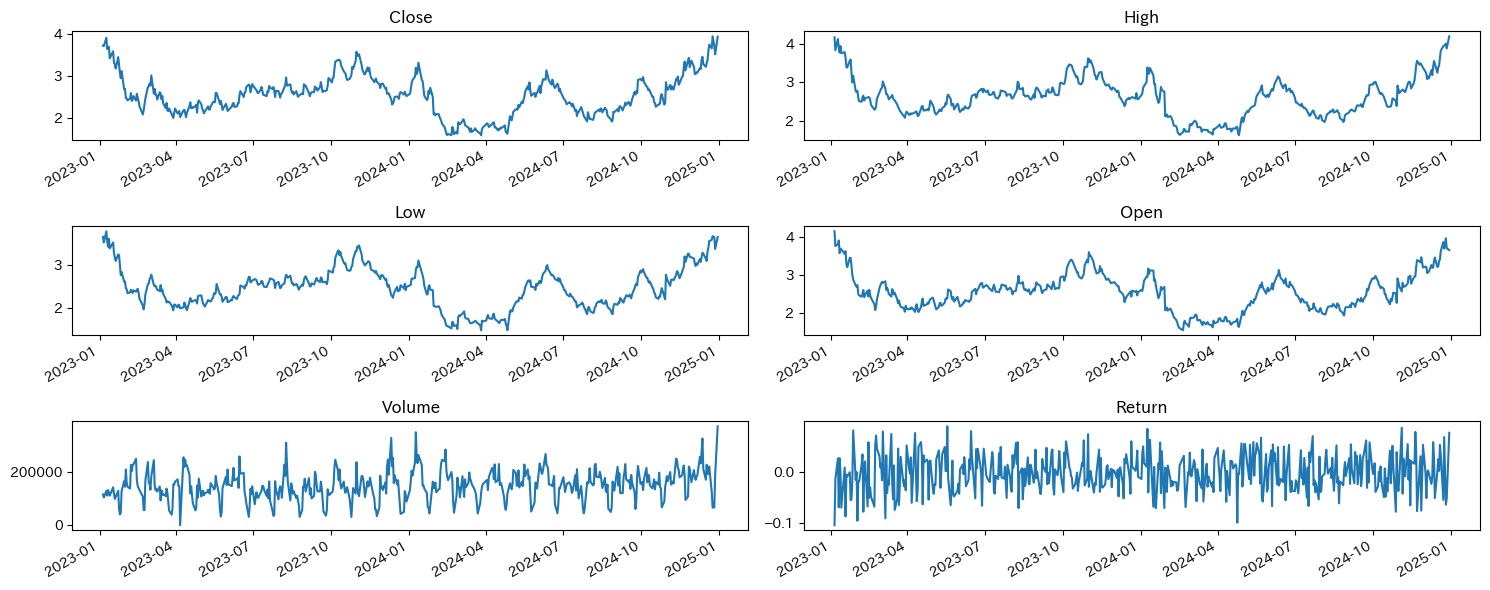

In [25]:
feature_ohlcv = get_ohlcv_yf(feature, start = start,end = end, interval= interval)
plot_ohclv(feature_ohlcv)
feature_ohlcv.isnull().sum()


In [26]:
merged_df = objective_ohlcv[["Close","High","Low","Open",'Return']].merge(feature_ohlcv[['Return']], left_index=True, right_index=True, suffixes=('_objective', '_feature'))
merged_df

,Close,High,Low,Open,Return_objective,Return_feature
2021-01-04,2150.768311,2189.774231,2144.872067,2175.260400,-0.011259,-0.017136
2021-01-05,2135.800781,2162.107098,2126.729638,2162.107098,-0.012167,0.039631
2021-01-06,2145.325684,2145.779241,2111.308892,2120.833593,0.011548,0.010417
2021-01-07,2158.479004,2192.949356,2154.850546,2188.413783,-0.013679,0.002572
2021-01-08,2175.260498,2177.981841,2133.986790,2144.872163,0.014168,0.009346
...,...,...,...,...,...,...
2024-12-23,4335.000000,4368.000000,4235.000000,4235.000000,0.023613,-0.055053
2024-12-24,4394.000000,4402.000000,4332.000000,4341.000000,0.012209,0.067930
2024-12-26,4376.000000,4391.000000,4354.000000,4368.000000,0.001832,-0.064232
2024-12-27,4425.000000,4425.000000,4375.000000,4400.000000,0.005682,-0.052064


In [27]:
strategy1 = merged_df.copy()
strategy1["Return_feature_s1"] = strategy1["Return_feature"].shift(1)
strategy1["Return_feature_s1_sign"] = np.sign(strategy1["Return_feature_s1"])

<Axes: title={'center': 'Return_feature_s1_sign'}, xlabel='Return_feature_s1_sign'>

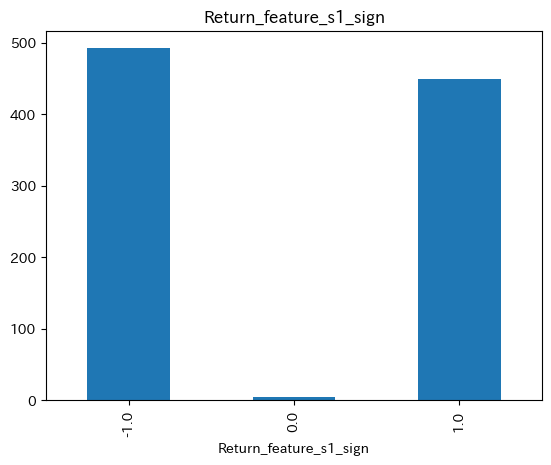

In [28]:
plt.title("Return_feature_s1_sign")
strategy1.groupby("Return_feature_s1_sign").size().plot(kind="bar")

Text(0, 0.5, 'Feature 1')

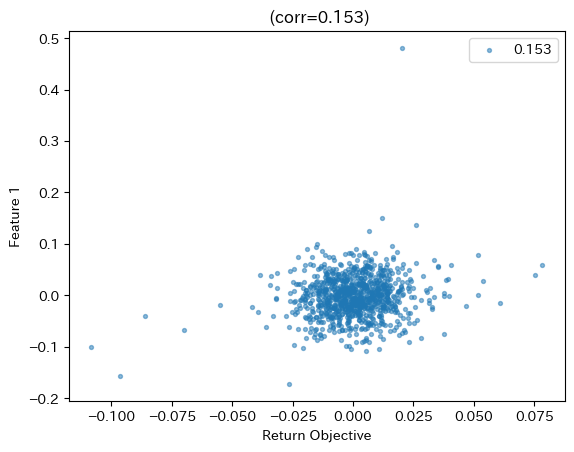

In [29]:
plot_corr(strategy1["Return_objective"],strategy1["Return_feature_s1"])
plt.xlabel("Return Objective")
plt.ylabel("Feature 1")

In [30]:
strategy1["signal"] = 0
strategy1.loc[strategy1["Return_feature_s1_sign"] == 1,"signal"] = 1
strategy1.loc[strategy1["Return_feature_s1_sign"] == -1,"signal"] = -1

# strategy1.loc[strategy1["Return_feature_s1"] < 0.00,"signal"] = -0.5
# strategy1.loc[strategy1["Return_feature_s1"] < -0.05,"signal"] = -1
# strategy1.loc[strategy1["Return_feature_s1"] > 0.00,"signal"] = 0.5
# strategy1.loc[strategy1["Return_feature_s1"] > 0.05,"signal"] = 1
print(strategy1["signal"].value_counts())

strategy1['pnl'] = strategy1["signal"]*strategy1["Return_objective"]
strategy1['dd'] = strategy1["pnl"].cumsum().cummax() - strategy1["pnl"].cumsum()
strategy1

signal
-1    492
 1    449
 0      5
Name: count, dtype: int64


,Close,High,Low,Open,Return_objective,Return_feature,Return_feature_s1,Return_feature_s1_sign,signal,pnl,dd
2021-01-04,2150.768311,2189.774231,2144.872067,2175.260400,-0.011259,-0.017136,NaN,NaN,0,-0.000000,0.000000
2021-01-05,2135.800781,2162.107098,2126.729638,2162.107098,-0.012167,0.039631,-0.017136,-1.0,-1,0.012167,0.000000
2021-01-06,2145.325684,2145.779241,2111.308892,2120.833593,0.011548,0.010417,0.039631,1.0,1,0.011548,0.000000
2021-01-07,2158.479004,2192.949356,2154.850546,2188.413783,-0.013679,0.002572,0.010417,1.0,1,-0.013679,0.013679
2021-01-08,2175.260498,2177.981841,2133.986790,2144.872163,0.014168,0.009346,0.002572,1.0,1,0.014168,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,4335.000000,4368.000000,4235.000000,4235.000000,0.023613,-0.055053,0.031938,1.0,1,0.023613,0.025816
2024-12-24,4394.000000,4402.000000,4332.000000,4341.000000,0.012209,0.067930,-0.055053,-1.0,-1,-0.012209,0.038025
2024-12-26,4376.000000,4391.000000,4354.000000,4368.000000,0.001832,-0.064232,0.067930,1.0,1,0.001832,0.036193
2024-12-27,4425.000000,4425.000000,4375.000000,4400.000000,0.005682,-0.052064,-0.064232,-1.0,-1,-0.005682,0.041875


SR(daily): 0.08535
SR(yearly): 1.63063
最大DD: 0.21811


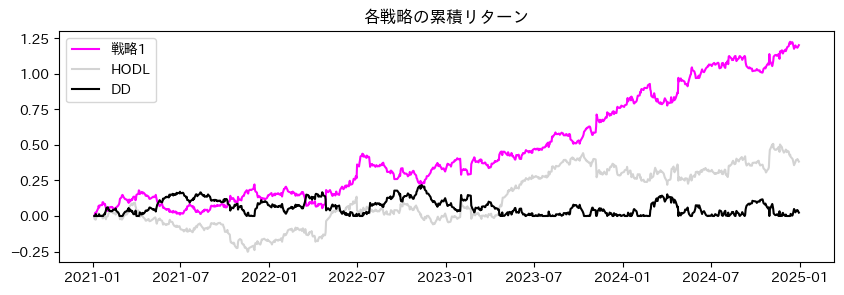

In [31]:
fig = plt.figure(figsize=(10,3))
plt.title("各戦略の累積リターン")
plt.plot(strategy1['pnl'].cumsum(),label="戦略1",color='magenta')
plt.plot(strategy1["Return_objective"].cumsum(), label='HODL', color='lightgray')
plt.plot(strategy1['dd'], label='DD', color='k')
plt.legend()
sr_daily = strategy1["pnl"].mean()/strategy1["pnl"].std()
sr_anual = sr_daily * np.sqrt(365)
print(f'SR(daily): {sr_daily:.5f}')
print(f'SR(yearly): {sr_anual:.5f}')
print(f'最大DD: {strategy1["dd"].max():.5f}')

In [32]:
class TakerBackTest:

    def __init__(self, collateral, leverage):
        self.collateral = collateral
        self.leverage = leverage
        self.maker_fee = 0.000  # 株コム api経由の信用取引は手数料無料
        self.taker_fee = 0.000 # 株コム api経由の信用取引は手数料無料
        self.slippage = 0.000

    def round_size(self, size):
        # サイズの最小で丸める. こ
        return round(size, 4)
    
    def run(self, data_with_signal):
        # DataFrameは重いので, np.Arrayまたはlistで計算を行う.
        df = data_with_signal.copy()
        
        # 使用データ.
        open_prices = df['Open'].values
        high_prices = df['High'].values
        low_prices = df['Low'].values
        close_prices = df['Close'].values
        signals = df['signal'].values  # signal列に-1～1が入っている想定.

        # バックテストにより計算するデータ.
        positions = []
        pnls = []
        fees = []
        max_losses = []
        balances = []

        # 前回のループの内容を保持するデータ.
        pre_signal = 0
        pre_position = 0
        pre_balance = self.collateral
        
        for i in range(len(df)):
            if signals[i] == pre_signal:
                position = pre_position
            else:
                position = pre_balance / open_prices[i] * self.leverage * signals[i]
            pnl = position * (close_prices[i] - open_prices[i])
            fee = abs(position - pre_position) * open_prices[i] * (self.taker_fee + self.slippage)
            max_loss = position * (low_prices[i] - open_prices[i]) if position >= 0 else position * (high_prices[i] - open_prices[i])
            balance = pre_balance + pnl - fee
            positions.append(position)
            pnls.append(pnl)
            fees.append(fee)
            max_losses.append(max_loss)
            balances.append(balance)
            pre_signal = signals[i]
            pre_position = positions[i]
            pre_balance = balances[i]
        df['position'] = positions
        df['pnl'] = pnls
        df['fee'] = fees
        df['max_loss'] = max_losses
        df['balance'] = balances
        df['max_dd'] = df['balance'].cummax() - df['balance']
        return df

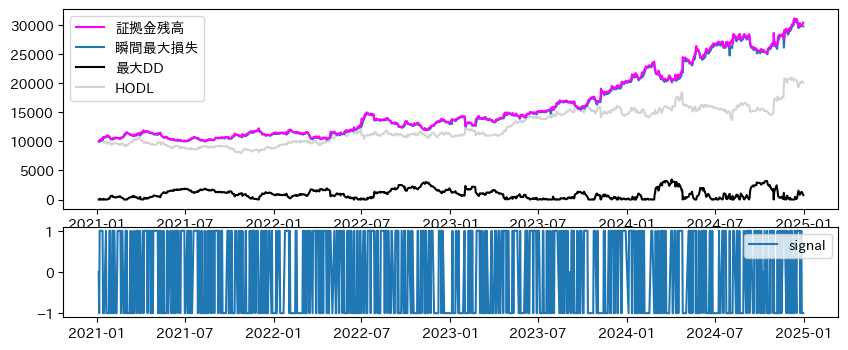

In [33]:
back_test = TakerBackTest(collateral=10000, leverage=1)
result = back_test.run(strategy1)
plt.figure(figsize=(10, 4))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
plt.plot(result['max_dd'], label='最大DD', color='k')
plt.plot(10000 / result['Open'].iloc[0] * result['Close'], label='HODL', color='lightgray', zorder=0)
plt.legend()
plt.subplot2grid((3, 1), (2, 0))
plt.plot(result['signal'], label='signal')
plt.legend()

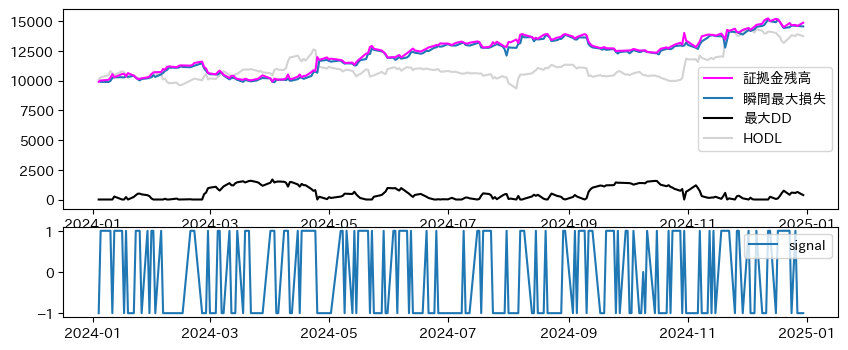

In [34]:
back_test = TakerBackTest(collateral=10000, leverage=1)
result = back_test.run(strategy1['2024':'2024'])
plt.figure(figsize=(10, 4))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
plt.plot(result['max_dd'], label='最大DD', color='k')
plt.plot(10000 / result['Open'].iloc[0] * result['Close'], label='HODL', color='lightgray', zorder=0)
plt.legend()
plt.subplot2grid((3, 1), (2, 0))
plt.plot(result['signal'], label='signal')
plt.legend()